In [287]:
import warnings
import numpy as np
import pandas as pd
import statsmodels.api as sm
import quantstats as qs
from utils import *
from statsmodels.api import OLS
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [288]:
df = pd.read_parquet('data/market_data_w_z_scores.parquet')
sp500 = pd.read_parquet('data/sp500_index_data.parquet')
sp500['date'] = pd.to_datetime(sp500['caldt'])
sp500.set_index('date', inplace=True)
# Calculate compounded returns for each month
monthly_sp500 = sp500['vwretx'].resample('M').apply(lambda x: (1 + x).prod() - 1).reset_index()
monthly_sp500 = monthly_sp500[['date', 'vwretx']]
monthly_sp500['cumret'] = (1 + monthly_sp500['vwretx']).cumprod()
monthly_sp500.set_index('date', inplace=True)
df.head()

,date,permno,beme,momentum,ann_ret,vwretx,mthret,me,alpha,beme_beta,momentum_beta,market_beta,predict,cs_alpha,cs_beme_beta,cs_momentum_beta,cs_market_beta,cs_predict
636,1964-08-31,10006,0.778226,NaN,-0.019139,-0.016279,0.012792,231786.5,NaN,NaN,NaN,NaN,NaN,0.003581,0.014219,-0.43008,-0.725584,NaN
637,1964-09-30,10006,0.778226,NaN,-0.098498,0.029022,0.074722,249106.0,NaN,NaN,NaN,NaN,NaN,0.003581,0.014219,-0.43008,-0.725584,NaN
638,1964-10-31,10006,0.778226,NaN,-0.029525,0.007657,0.029586,256476.0,NaN,NaN,NaN,NaN,NaN,0.003581,0.014219,-0.43008,-0.725584,NaN
639,1964-11-30,10006,0.778226,NaN,-0.017443,-0.004660,-0.023469,248369.0,NaN,NaN,NaN,NaN,NaN,0.003581,0.014219,-0.43008,-0.725584,NaN
640,1964-12-31,10006,0.778226,NaN,0.121360,0.003802,-0.056380,235956.0,NaN,NaN,NaN,NaN,NaN,0.003581,0.014219,-0.43008,-0.725584,NaN


In [291]:
df['Position'] = 0
df['z_quantile'] = pd.qcut(df['predict'], 4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
df.loc[(df['z_quantile'] == 'High'), 'Position'] = 1
df.loc[(df['z_quantile'] == 'Low'), 'Position'] = -1

<Axes: xlabel='date'>

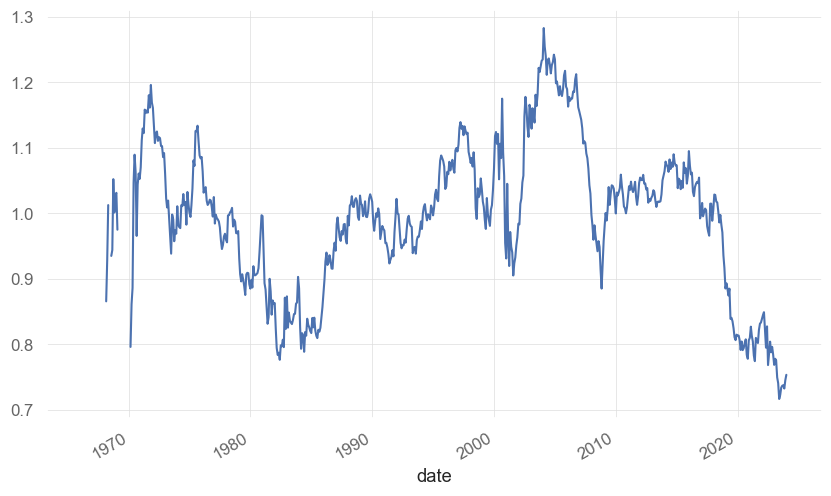

In [292]:
#Equal weight portfolio
long_returns = df[df['Position'] == 1].groupby('date')['mthret'].mean()
short_returns = df[df['Position'] == -1].groupby('date')['mthret'].mean()
long_short_returns = long_returns - short_returns
ew_long_short_returns = long_short_returns
(1 + ew_long_short_returns).cumprod().plot()
# monthly_sp500['cumret'].plot()

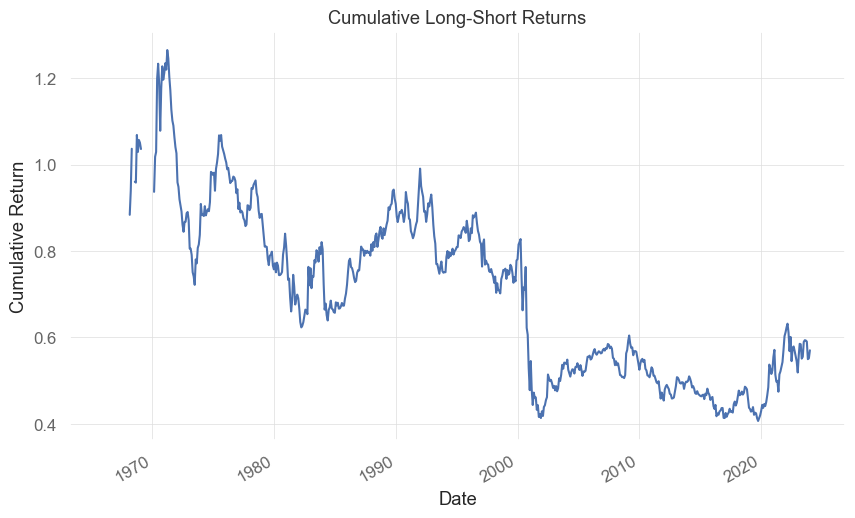

In [293]:
# Initialize Position weights to NaN
df['long_weight'] = None
df['short_weight'] = None
df['lag_me'] = df.groupby('permno')['me'].shift(1)
df.loc[df['Position'] == 1, 'long_weight'] = df[df['Position'] == 1].groupby('date')['lag_me'].transform(lambda x: x / x.sum())
df.loc[df['Position'] == -1, 'short_weight'] = df[df['Position'] == -1].groupby('date')['lag_me'].transform(lambda x: x / x.sum())

df['me_weight'] = np.where(df['Position'] == 1, df['long_weight'], 
                            np.where(df['Position'] == -1, df['short_weight'], 0))
df['me_weight'] = df['me_weight'].fillna(0)

df['weighted_returns'] = df['mthret'] * df['me_weight']

long_returns = df[df['Position'] == 1].groupby('date')['weighted_returns'].sum()
short_returns = df[df['Position'] == -1].groupby('date')['weighted_returns'].sum()

# Calculate the long-short returns
vw_long_short_returns = long_returns - short_returns
plt.figure(figsize=(10, 6))
(1 + vw_long_short_returns).cumprod().plot(title="Cumulative Long-Short Returns")
# monthly_sp500['cumret'].plot()
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.show()

In [294]:
ew_long_short_returns = ew_long_short_returns.to_frame().fillna(0)
vw_long_short_returns = vw_long_short_returns.to_frame().fillna(0)
ew_long_short_returns.to_parquet('data/ew_long_short_returns.parquet')
vw_long_short_returns.to_parquet('data/vw_long_short_returns.parquet')

In [295]:
ew_long_short_returns = ew_long_short_returns[ew_long_short_returns.index >= '1975-07-31']

Observing the Basic reports, the portfolio does poorly, in equal and value-weighted schemes with Sharpes of -0.07 and -0.03 respectively. This is in-line with our expectation, we have weak monotonicity in our predictions, few factors, low R2, and no risk management.

                    Strategy
------------------  ----------
Start Period        1975-07-31
End Period          2023-12-31
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   -33.06%
CAGR﹪              -0.57%

Sharpe              -0.07
Prob. Sharpe Ratio  31.4%
Sortino             -0.1
Sortino/√2          -0.07
Omega               0.95

Max Drawdown        -44.14%
Longest DD Days     7823

Gain/Pain Ratio     -0.05
Gain/Pain (1M)      -0.05

Payoff Ratio        1.09
Profit Factor       0.95
Common Sense Ratio  1.05
CPC Index           0.48
Tail Ratio          1.11
Outlier Win Ratio   3.41
Outlier Loss Ratio  3.86

MTD                 1.11%
3M                  2.26%
6M                  5.14%
YTD                 -1.98%
1Y                  -3.95%
3Y (ann.)           -1.69%
5Y (ann.)           -2.24%
10Y (ann.)          -2.31%
All-time (ann.)     -0.57%

Avg. Drawdown       -17.16%
Avg. Drawdown Days  2449
Recovery Factor     0.59
Ulcer Index         0.2
Serenity Index 

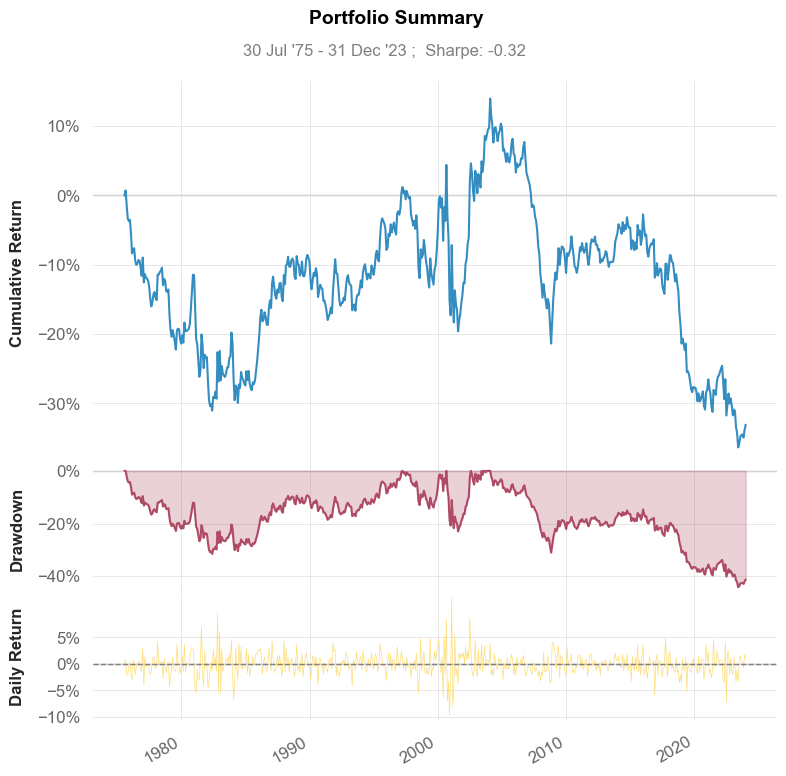

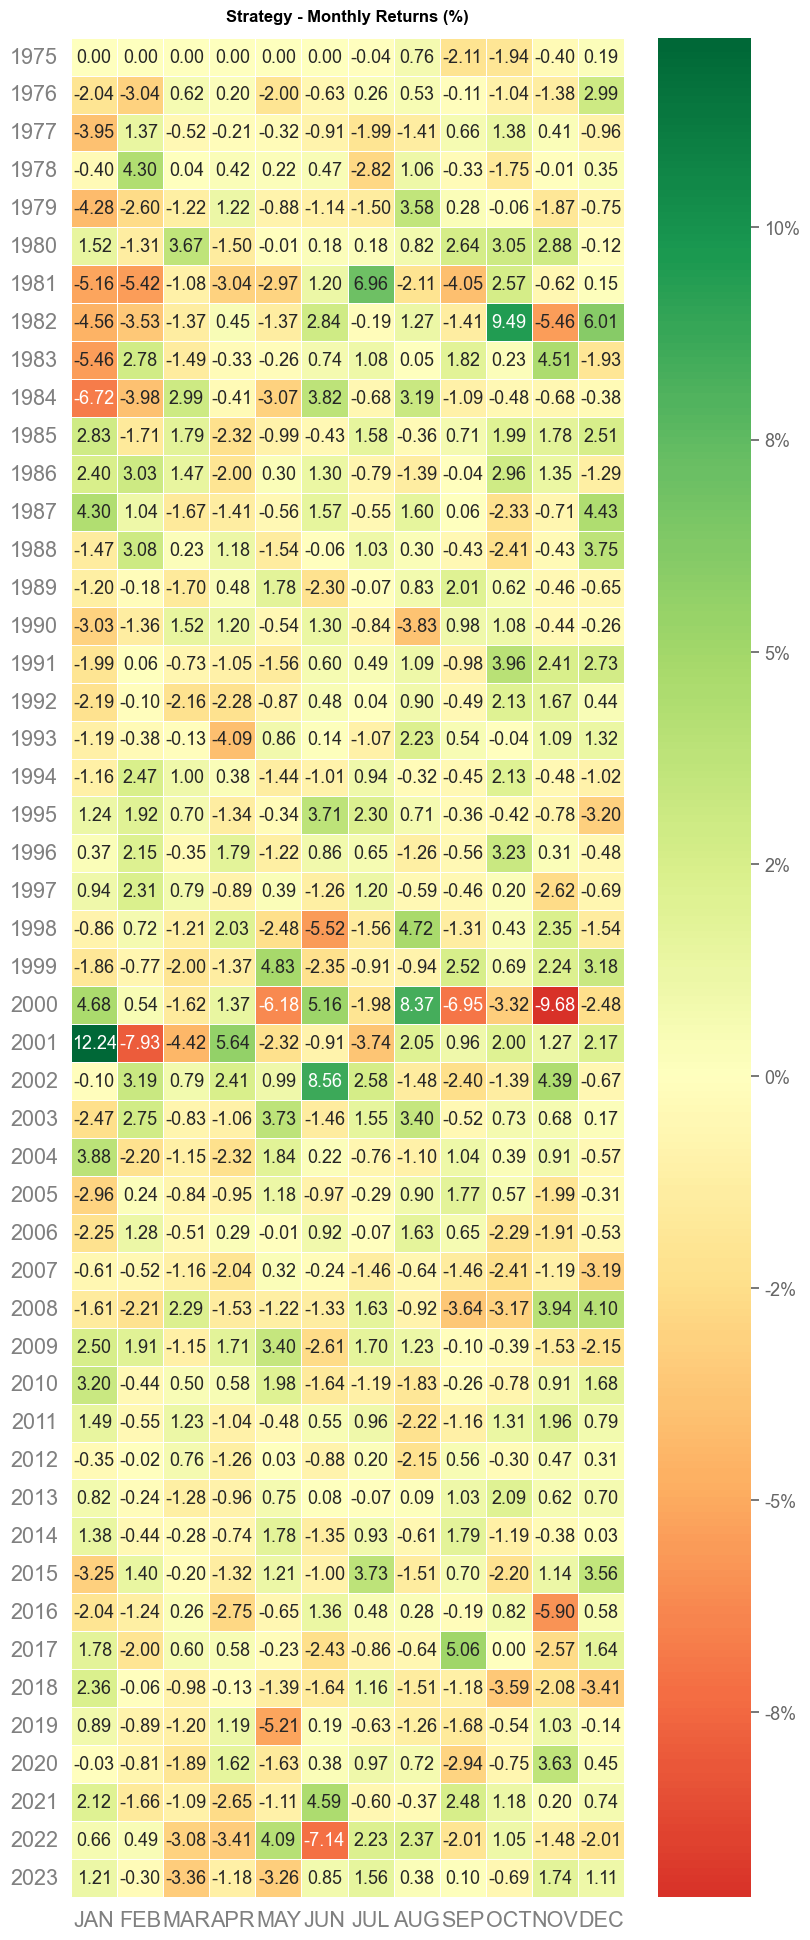

In [296]:
#Evaluation of Equal Weight Strategy
qs.reports.basic(ew_long_short_returns['mthret'], title='Equal Weight Value + Momentum Strategy', output='evaluation_figs/ew_long_short_returns.html', periods_per_year=12)

                    Strategy
------------------  ----------
Start Period        1966-02-28
End Period          2023-12-31
Risk-Free Rate      0.0%
Time in Market      96.0%

Cumulative Return   -42.99%
CAGR﹪              -0.67%

Sharpe              -0.03
Prob. Sharpe Ratio  41.79%
Sortino             -0.04
Sortino/√2          -0.03
Omega               0.98

Max Drawdown        -67.85%
Longest DD Days     19239

Gain/Pain Ratio     -0.02
Gain/Pain (1M)      -0.02

Payoff Ratio        1.06
Profit Factor       0.98
Common Sense Ratio  1.01
CPC Index           0.5
Tail Ratio          1.03
Outlier Win Ratio   4.44
Outlier Loss Ratio  4.34

MTD                 3.38%
3M                  -3.82%
6M                  2.69%
YTD                 9.89%
1Y                  4.73%
3Y (ann.)           0.67%
5Y (ann.)           3.8%
10Y (ann.)          0.95%
All-time (ann.)     -0.67%

Avg. Drawdown       -18.9%
Avg. Drawdown Days  3400
Recovery Factor     0.27
Ulcer Index         0.46
Serenity Index     

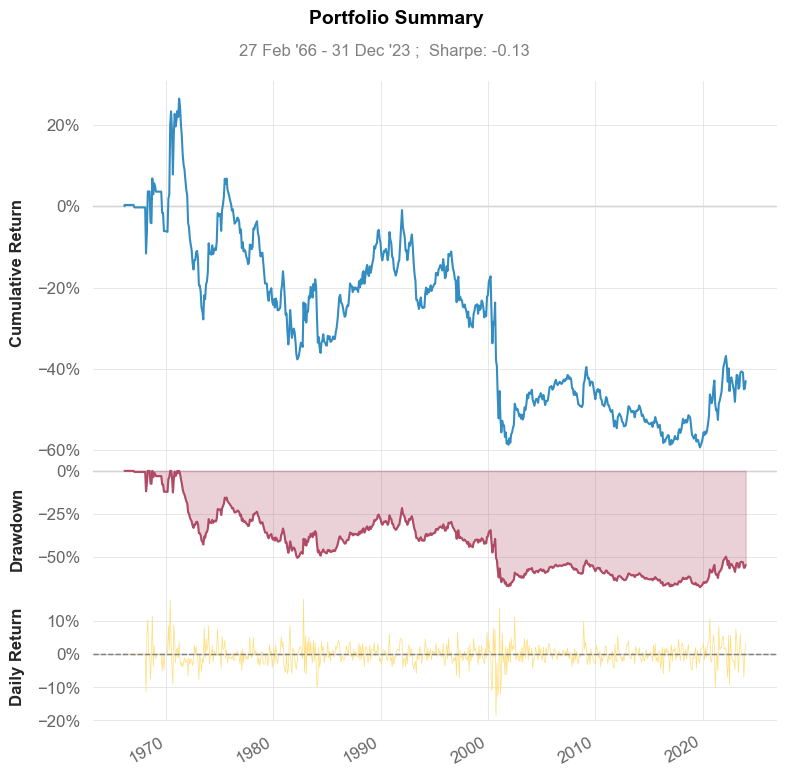

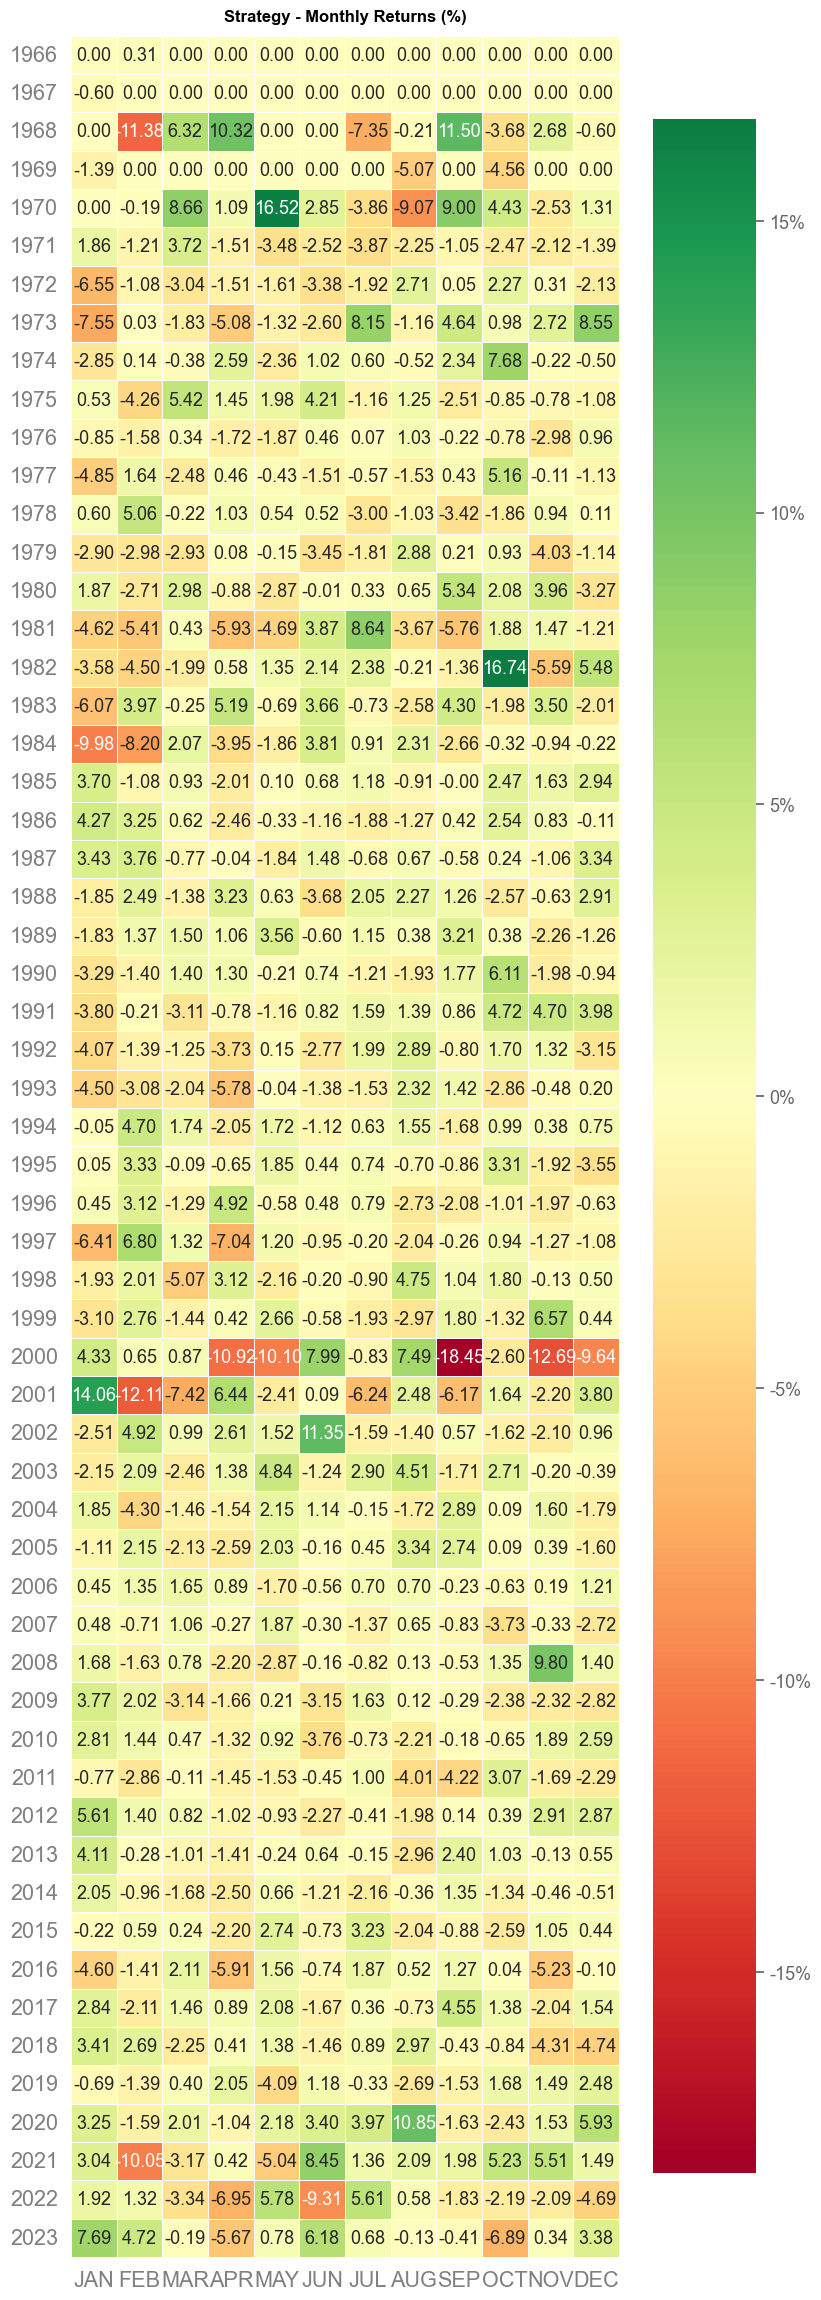

In [298]:
qs.reports.basic(vw_long_short_returns['weighted_returns'], title='Value Weight Value + Momentum Strategy', output='evaluation_figs/vw_long_short_returns.html', periods_per_year=12)